# Machine Learning Project:
## Musical Instrument Classification (Natural and Synthetic)
This program was our first attempt using the JSON version of the NSynth dataset found at https://magenta.tensorflow.org/datasets/nsynth#files. We chose to work with this format because it was much easier to read, however, the audio files for each sample were not included. Using only the source (acoustic, electronic, or synthetic), the velocity, and the pitch of the sample, we tried to classify test samples by instrument family. Unfortunately, the accuracy of our neural net classifier was low without the actual audio samples.

### Load Keras and other libraries

In [2]:
import keras
import json
from pprint import pprint

Using TensorFlow backend.


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import librosa
import librosa.display
import librosa.feature

### Load JSON files
Load both the training and test datasets. Each set of data contains both the classifiers and labels, so the features were read and then placed into X matrices and y vectors for training and testing.

In [79]:
#https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/
# https://stackoverflow.com/questions/2835559/parsing-values-from-a-json-file
Xtr = json.load(open('nsynth_train.json'))
Xts = json.load(open('nsynth_test.json'))
Xtr_str = list(Xtr.keys())
Xts_str = list(Xts.keys())

# Print example to see that the data loaded correctly
#pprint(Xtr['guitar_acoustic_001-082-050'])
pprint(Xtr[Xtr_str[0]]) # equivalent to line above

X_train = np.zeros([len(Xtr),3])
ytr=np.zeros(len(Xtr))
for i in range(0,len(Xtr)):
    ytr[i]=Xtr[Xtr_str[i]]['instrument_family']
    X_train[i,0] = Xtr[Xtr_str[i]]['instrument_source']
    X_train[i,1] = Xtr[Xtr_str[i]]['velocity']
    X_train[i,2] = Xtr[Xtr_str[i]]['pitch']
print(ytr[0:5]) # View the first 5 samples
print(X_train[0:5,:])

X_test = np.zeros([len(Xts),3])
yts=np.zeros(len(Xts))
for i in range(0,len(Xts)):
    yts[i]=Xts[Xts_str[i]]['instrument_family']
    X_test[i,0] = Xts[Xts_str[i]]['instrument_source']
    X_test[i,1] = Xts[Xts_str[i]]['velocity']
    X_test[i,2] = Xts[Xts_str[i]]['pitch']
print(yts[0:5])
print(X_test[0:5,:])

{'instrument': 39,
 'instrument_family': 3,
 'instrument_family_str': 'guitar',
 'instrument_source': 0,
 'instrument_source_str': 'acoustic',
 'instrument_str': 'guitar_acoustic_001',
 'note': 16629,
 'note_str': 'guitar_acoustic_001-082-050',
 'pitch': 82,
 'qualities': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'qualities_str': ['percussive'],
 'sample_rate': 16000,
 'velocity': 50}
[ 3.  0.  6.  3.  6.]
[[   0.   50.   82.]
 [   2.   50.  108.]
 [   1.  127.   50.]
 [   1.   25.   26.]
 [   1.   75.   79.]]
[ 0.  4.  3.  7.  2.]
[[   2.   25.   49.]
 [   1.  127.   21.]
 [   0.  100.   66.]
 [   0.  127.   68.]
 [   0.  100.   77.]]


We also printed the lengths of the datasets. The training set contains 289,205 samples each containing source, pitch, and velocity information. Each sample has a unique label that describes the instrument family and source.

In [22]:
print(len(Xtr))  # number of samples
print(len(Xts))  # number of features
print(len(Xtr.keys()))
list(Xtr.keys()) # files names

289205
4096
289205


['guitar_acoustic_001-082-050',
 'bass_synthetic_120-108-050',
 'organ_electronic_120-050-127',
 'guitar_electronic_021-026-025',
 'organ_electronic_011-079-075',
 'keyboard_electronic_089-044-100',
 'bass_synthetic_016-080-127',
 'keyboard_acoustic_010-084-127',
 'keyboard_acoustic_011-053-127',
 'keyboard_electronic_100-040-025',
 'vocal_synthetic_012-086-100',
 'vocal_synthetic_007-064-025',
 'organ_electronic_002-068-100',
 'keyboard_electronic_065-069-025',
 'guitar_electronic_035-062-127',
 'organ_electronic_111-065-100',
 'keyboard_electronic_087-092-050',
 'string_acoustic_006-075-025',
 'bass_synthetic_037-092-050',
 'reed_acoustic_041-065-127',
 'flute_acoustic_030-067-100',
 'mallet_electronic_001-105-075',
 'bass_synthetic_004-049-050',
 'guitar_electronic_004-061-050',
 'bass_synthetic_130-072-100',
 'bass_synthetic_020-067-050',
 'string_acoustic_075-056-050',
 'string_acoustic_069-041-050',
 'keyboard_electronic_097-047-075',
 'reed_acoustic_051-052-025',
 'bass_syntheti

Each sample actually has 13 features. We only chose the source, pitch, and velocity because many of the other features are string identifiers like the labels shown above. The features we chose were relevant to the qualities that define the audio samples.

In [50]:
print(len(Xtr[Xtr_str[0]].values()))

13


### Building the neural network classifier
Using the same structure of the model from Lab 7, we built a neural network based on the data.

In [43]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

Clear session

In [44]:
import keras.backend as K
K.clear_session()

Construct the model based on the size of the input and output.

In [125]:
nin = 3      # number of classifiers: source, pitch, & velocity
nh = 200     # number of hidden units
nout = 11    # number of possible outputs, instrument family

print(nout)
print(nin)
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

11
3


In [126]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 200)               800       
_________________________________________________________________
output (Dense)               (None, 11)                2211      
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


Same callback function from lab 7 to keep track of the loss history and validation accuracy

In [127]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.valu_acc = []
 
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        self.valu_acc.append(logs.get('acc'))
        
# Create an instance of the history callback
history_cb = LossHistory()

And the same optimizer as well

In [128]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Classify test data
We then fit the model to 10 epochs. Unfortunately, there is very little improvement in the accuracy. It only reaches about 43%. Part of this can be attributed to the small dataset without the audio signals. Pitch and velocity probably do not say enough about an audio sample to classify it. We could also try running the model longer, but the model would probably only give diminishing returns.

In [129]:
batch_size = 100
model.fit(X_train, ytr, epochs=10, batch_size=100, validation_data=(X_test,yts), callbacks = [history_cb])

Train on 289205 samples, validate on 4096 samples
Epoch 1/10
289205/289205 [==============================] - 12s - loss: 1.7179 - acc: 0.4069 - val_loss: 1.6961 - val_acc: 0.3457
Epoch 2/10
289205/289205 [==============================] - 6s - loss: 1.5526 - acc: 0.4317 - val_loss: 1.5853 - val_acc: 0.3569
Epoch 3/10
289205/289205 [==============================] - 5s - loss: 1.5202 - acc: 0.4317 - val_loss: 1.5925 - val_acc: 0.3726
Epoch 4/10
289205/289205 [==============================] - 6s - loss: 1.5121 - acc: 0.4314 - val_loss: 1.5816 - val_acc: 0.3652
Epoch 5/10
289205/289205 [==============================] - 6s - loss: 1.5073 - acc: 0.4319 - val_loss: 1.5676 - val_acc: 0.3499
Epoch 6/10
289205/289205 [==============================] - 6s - loss: 1.5045 - acc: 0.4324 - val_loss: 1.5780 - val_acc: 0.3418
Epoch 7/10
289205/289205 [==============================] - 6s - loss: 1.5028 - acc: 0.4310 - val_loss: 1.5845 - val_acc: 0.3516
Epoch 8/10
289205/289205 [====================

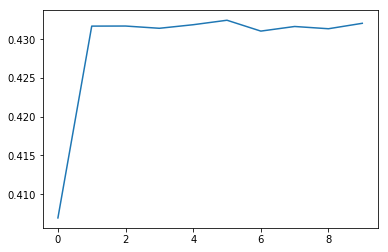

In [130]:
plt.plot(history_cb.valu_acc)